In [ ]:
!pip install node2vec  # If not installed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm
import community as Louvain_community

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity

## Loading & Exploring Real Graph Datasets

[SNAP dataset](https://snap.stanford.edu/data/)

[Citation network](https://snap.stanford.edu/data/cit-HepTh.html)

In [ ]:
# Paper citation network of Arxiv High Energy Physics Theory category
!wget https://snap.stanford.edu/data/cit-HepTh.txt.gz

# Time of nodes (paper submission time to Arxiv)
!wget https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz

# Paper meta information (see below)
!wget https://snap.stanford.edu/data/cit-HepTh-abstracts.tar.gz

In [ ]:
!tar -xzvf cit-HepTh-abstracts.tar.gz

In [ ]:
!7z x cit-HepTh-dates.txt.gz

In [ ]:
!7z x cit-HepTh.txt.gz

In [25]:
with open('/content/Cit-HepTh.txt', 'r') as file:
    lines = file.readlines()

lines[:6]

['# Directed graph (each unordered pair of nodes is saved once): Cit-HepTh.txt \n',
 '# Paper citation network of Arxiv High Energy Physics Theory category\n',
 '# Nodes: 27770 Edges: 352807\n',
 '# FromNodeId\tToNodeId\n',
 '1001\t9304045\n',
 '1001\t9308122\n']

In [45]:
# This method doesn't give me a good result, since node and edge number is not align with dataset metadata in website.
G = nx.read_edgelist(
    '/content/Cit-HepTh.txt',
    delimiter='\t',
    comments='#',
    create_using=nx.DiGraph
)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 48239, Edges: 352807


In [ ]:
edges_df = pd.read_csv(
    '/content/Cit-HepTh.txt',
    sep = '\t',
    comment = '#',
    names = ['FromNodeId', 'ToNodeId']
)

print(edges_df.head(3))

G = nx.from_pandas_edgelist(
    edges_df,
    source = 'FromNodeId',
    target = 'ToNodeId',
    create_using = nx.DiGraph()
)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

   FromNodeId  ToNodeId
0        1001   9304045
1        1001   9308122
2        1001   9309097
Nodes: 27770, Edges: 352807


In [81]:
print(f"- Density: {nx.density(G):.6f}")
print(f"- Average clustering coefficient: {nx.average_clustering(G):.6f}")

- Density: 0.000458
- Average clustering coefficient: 0.156925


In [82]:
with open('/content/Cit-HepTh-dates.txt', 'r') as f:
    lines = f.readlines()
lines[:4]

['# cross-listed papers have ids 11<true_id>\n',
 '9203201\t1992-02-24\n',
 '9203202\t1992-03-08\n',
 '9203203\t1992-03-03\n']

In [83]:
time_df = pd.read_csv(
    '/content/Cit-HepTh-dates.txt',
    sep = '\t',
    comment = '#',
    names = ['NodeId', 'date']
)

time_df.head(3)

,NodeId,date
0,9203201,1992-02-24
1,9203202,1992-03-08
2,9203203,1992-03-03


In [84]:
time_df['date'] = pd.to_datetime(time_df['date'], format='%Y-%m-%d')
node_att = time_df.set_index('NodeId').to_dict()
nx.set_node_attributes(G, node_att, 'date')

In [87]:
# nx.draw(G, with_labels = True, node_color='lightblue')
# plt.show()

In [ ]:
def measure_centralities(G):
    centralities = {}
    computations = [
        ('degree_centrality', lambda: nx.degree_centrality(G)),
        ('betweenness_centrality', lambda: nx.betweenness_centrality(G)),
        ('closeness_centrality', lambda: nx.closeness_centrality(G)),
        ('eigenvector_centrality', lambda: nx.eigenvector_centrality(G, max_iter=1000)),
        ('pagerank', lambda: nx.pagerank(G))
    ]

    with tqdm(total=len(computations), desc="Computing Centralities") as pbar:
        for name, computation in computations:
            centralities[name] = computation()
            pbar.set_postfix({"current": name})
            pbar.update(1)

    return centralities

centralities = measure_centralities(G)

for k, v in centralities:
    top_n = sorted(v.items(), key = lambda x: x[1], reverse=True)[:3]
    print(k, top_n)

In [97]:
wcc = list(nx.weakly_connected_components(G))
sub_g_w = G.subgraph(wcc[0])
print(f"Nodes: {sub_g_w.number_of_nodes()}, Edges: {sub_g_w.number_of_edges()}")

Nodes: 27400, Edges: 352542


In [109]:
scc = list(nx.strongly_connected_components(G))
maximum = 0
for item in scc:
    if len(item) > maximum:
        maximum = len(item)
        sub_g_s = G.subgraph(item)
print(f"Nodes: {sub_g_s.number_of_nodes()}, Edges: {sub_g_s.number_of_edges()}")

Nodes: 7464, Edges: 116268


## little Facebook dataset

[Link](https://snap.stanford.edu/data/ego-Facebook.html)

In [ ]:
!wget https://snap.stanford.edu/data/facebook.tar.gz
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz
!wget https://snap.stanford.edu/data/readme-Ego.txt

In [ ]:
!tar -xzvf facebook.tar.gz

In [ ]:
!7z x facebook_combined.txt.gz

In [122]:
with open('/content/readme-Ego.txt', 'r') as f:
    lines = f.read()
print(lines)

Files:

nodeId.edges : The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

nodeId.circles : The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

nodeId.feat : The features for each of the nodes that appears in the edge file.

nodeId.egofeat : The features for the ego user.

nodeId.featnames : The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.



In [129]:
# Check lines to understand structure
#   does it have comments?
#   how data seprated? '\t' ' ' ','
with open('/content/facebook_combined.txt', 'r') as f:
    lines = f.readlines()

lines[:4]

['0 1\n', '0 2\n', '0 3\n', '0 4\n']

In [3]:
edge_df = pd.read_csv(
    '/content/facebook_combined.txt',
    sep = ' ',
    names = ['FromNodeId', 'ToNodeId']
)

G = nx.from_pandas_edgelist(
    edge_df,
    source='FromNodeId',
    target='ToNodeId',
    create_using=nx.DiGraph()
)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 4039, Edges: 88234


In [4]:
scc = list(nx.strongly_connected_components(G))
wcc = list(nx.weakly_connected_components(G))

In [148]:
sub_w = G.subgraph(wcc[0])
print('Weakly connected components')
print(f"Nodes: {sub_w.number_of_nodes()}, Edges: {sub_w.number_of_edges()}")

Weakly connected components
Nodes: 4039, Edges: 88234


In [149]:
sub_s = G.subgraph(max(wcc, key = len))
print('Strongly connected components')
print(f"Nodes: {sub_s.number_of_nodes()}, Edges: {sub_s.number_of_edges()}")

Strongly connected components
Nodes: 4039, Edges: 88234


In [20]:
# The graph is undirected in prevouce cells we wanted to calculate scc and wcc
G = nx.from_pandas_edgelist(
    edge_df,
    source = 'FromNodeId',
    target = 'ToNodeId',
    create_using = nx.Graph()
)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 4039, Edges: 88234


In [19]:
print(f"- Density: {nx.density(G):.6f}")
print(f"- Average clustering coefficient: {nx.average_clustering(G):.6f}")

- Density: 0.010820
- Average clustering coefficient: 0.605547


In [ ]:
def measure_centralities(G):
    centralities = {}
    computations = [
        ('degree_centrality', lambda: nx.degree_centrality(G)),
        ('betweenness_centrality', lambda: nx.betweenness_centrality(G)),
        ('closeness_centrality', lambda: nx.closeness_centrality(G)),
        ('eigenvector_centrality', lambda: nx.eigenvector_centrality(G, max_iter=1000)),
        ('pagerank', lambda: nx.pagerank(G))
    ]

    with tqdm(total=len(computations), desc="Computing Centralities") as pbar:
        for name, computation in computations:
            pbar.set_postfix({"current": name})
            centralities[name] = computation()
            pbar.update(1)

    return centralities

centralities = measure_centralities(G)

Computing Centralities:   0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
centralities_df = pd.DataFrame(centralities)
print(centralities_df.shape)
centralities_df.head()

(4039, 5)


,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,0.085934,1.463059e-01,0.353343,3.391796e-05,0.006290
1,0.004210,2.783274e-06,0.261376,6.045346e-07,0.000236
2,0.002476,7.595021e-08,0.261258,2.233461e-07,0.000203
3,0.004210,1.685066e-06,0.261376,6.635648e-07,0.000226
4,0.002476,1.840332e-07,0.261258,2.236416e-07,0.000238


In [23]:
for k, v in centralities.items():
    top_n = sorted(v.items(), key = lambda x: x[1], reverse=True)[:3]
    print(k, top_n)

degree_centrality [(107, 0.258791480931154), (1684, 0.1961367013372957), (1912, 0.18697374938088163)]
betweenness_centrality [(107, 0.4805180785560152), (1684, 0.3377974497301992), (3437, 0.23611535735892905)]
closeness_centrality [(107, 0.45969945355191255), (58, 0.3974018305284913), (428, 0.3948371956585509)]
eigenvector_centrality [(1912, 0.09540696149067629), (2266, 0.08698327767886552), (2206, 0.08605239270584342)]
pagerank [(3437, 0.0076145868447496), (107, 0.006936420955866117), (1684, 0.006367162138306824)]


In [ ]:
methods =[
    ("Louvain", lambda: Louvain_community.best_partition(G)), # only for undirected graphs
    ("Greedy", lambda: nx.community.greedy_modularity_communities(G)),
    ("Girvan Newman", lambda: nx.community.girvan_newman(G)),
    ("Label Propagation", lambda: nx.community.label_propagation_communities(G)) # only for undirected graphs
]

communities = {}
with tqdm(total=len(methods), desc="Computing Methods") as pbar:
    for name, comms in methods:
        pbar.set_postfix({"current": name})
        communities[name] = comms()
        pbar.update(1)

Computing Methods:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
louvain = dict(communities['Louvain'])
Greedy = list(communities['Greedy'])

louvain_comms = {}
for k, v in louvain.items():
    louvain_comms[v] = louvain_comms.get(v, []) + [k]

In [ ]:
from networkx.algorithms.community.quality import modularity


print(f"Greedy: Modularity = {modularity(G, Greedy):.4f}")
print(f"Louvain: Modularity = {modularity(G, louvain_comms.values()):.4f}")

Greedy: Modularity = 0.7774
Louvain: Modularity = 0.8349


In [46]:
community_metrics = []

for i, comms in tqdm(enumerate(louvain_comms.values()), total=len(louvain_comms.values())):
    subgraph = G.subgraph(comms)

    n = subgraph.number_of_nodes()
    e = subgraph.number_of_edges()
    total_degree = sum(d for _, d in G.degree(comms))
    cuts = total_degree - 2 * e

    # Global
    coverage = e / G.number_of_nodes()

    # internal
    density = nx.density(subgraph)
    clustering = nx.average_clustering(subgraph)

    # external
    conductance = cuts / total_degree
    expansion = cuts / n

    community_metrics.append({
        'community_id': i,
        'size': n,
        'coverage': coverage,
        'density': density,
        'clustering': clustering,
        'conductance': conductance,
        'expansion': expansion,
        'internal_edges': e,
        'cut_edges': cuts
    })


metrics_df = pd.DataFrame(community_metrics)
metrics_df

  0%|          | 0/17 [00:00<?, ?it/s]

,community_id,size,coverage,density,clustering,conductance,expansion,internal_edges,cut_edges
0,0,341,0.698935,0.048698,0.656204,0.006860,0.114370,2823,39
1,1,430,1.501362,0.065745,0.593528,0.064414,1.941860,6064,835
2,2,60,0.103243,0.235593,0.622079,0.226345,4.066667,417,244
3,3,442,4.144590,0.171761,0.582978,0.036158,2.841629,16740,1256
4,4,423,2.827928,0.127973,0.616820,0.052667,3.002364,11422,1270
5,5,535,2.151770,0.060842,0.516187,0.026818,0.895327,8691,479
6,6,324,1.561278,0.120514,0.564569,0.073873,3.104938,6306,1006
7,7,71,0.155979,0.253521,0.722201,0.103203,2.042254,630,145
8,8,548,1.326071,0.035736,0.624584,0.004183,0.082117,5356,45
9,9,73,0.367913,0.565449,0.694786,0.077305,3.410959,1486,249


## Anomaly detection

### Abnormal Nodes

In [48]:
node_list = list(G.nodes())

degree = [G.degree(n) for n in tqdm(node_list, desc = 'in_degree')]
# in_degree = [G.in_degree(n) for n in tqdm(node_list, desc = 'in_degree')]
# out_degree = [G.out_degree(n) for n in tqdm(node_list, desc = 'out_degree')]
pagerank = [centralities.get('pagerank', {}).get(n, 0) for n in tqdm(node_list, desc = 'pagerank')]
neighbors = [list(G.neighbors(n)) for n in tqdm(node_list, desc = 'neighbors')]
avg_neighbor_degree = [np.mean([G.degree(n) for n in neighbor]) for neighbor in tqdm(neighbors, desc = 'avg_neighbor_degree')]

in_degree:   0%|          | 0/4039 [00:00<?, ?it/s]

pagerank:   0%|          | 0/4039 [00:00<?, ?it/s]

neighbors:   0%|          | 0/4039 [00:00<?, ?it/s]

avg_neighbor_degree:   0%|          | 0/4039 [00:00<?, ?it/s]

In [50]:
# clustering = [nx.clustering(G.to_undirected(), n) for n in tqdm(node_list, desc = "clustering")]

In [51]:
features = np.vstack([degree, pagerank, avg_neighbor_degree]).T
features = np.nan_to_num(features) # Handle NaN values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(features)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

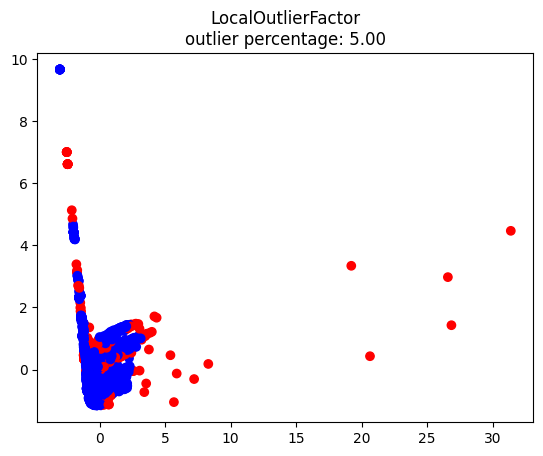

In [52]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=False)
lof_pred = lof.fit_predict(X)

color = ['red' if item == -1 else 'blue' for item in lof_pred]
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color)
plt.title(
    'LocalOutlierFactor\n'
    f'outlier percentage: {np.sum(lof_pred == -1) / len(lof_pred) * 100:.2f}'
)
plt.show()

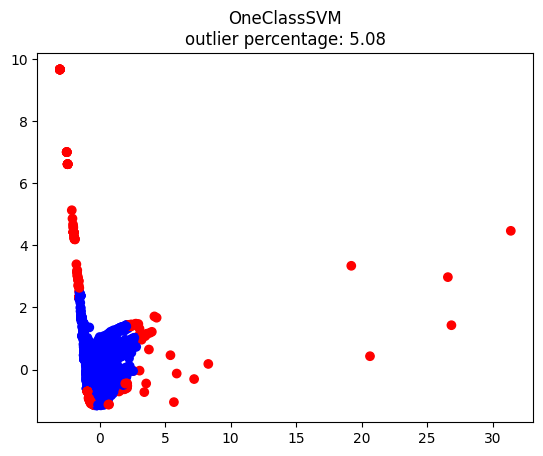

In [53]:
svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)
svm_pred = svm.fit_predict(X)

color = ['red' if item == -1 else 'blue' for item in svm_pred]
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = color)
plt.title(
    'OneClassSVM\n'
    f'outlier percentage: {np.sum(svm_pred == -1) / len(svm_pred) * 100:.2f}'
)
plt.show()

In [58]:
sample_size = 200

outlier_mask = (svm_pred == -1)
outlier_nodes = [node_list[i] for i in range(len(node_list)) if outlier_mask[i]]
print(f"Number of outliers: {len(outlier_nodes)}")
outlier_nodes = list(outlier_nodes)[:50]

normal_nodes = list(set(G.nodes()) - set(outlier_nodes))
sampled_normal = np.random.choice(
    normal_nodes, size=min(sample_size - len(outlier_nodes), len(normal_nodes)), replace=False
)
nodes_to_plot = outlier_nodes + list(sampled_normal)
node_colors = ['red' if node in outlier_nodes else 'blue' for node in nodes_to_plot]
node_sizes = [100 if node in outlier_nodes else 20 for node in nodes_to_plot]

Number of outliers: 205


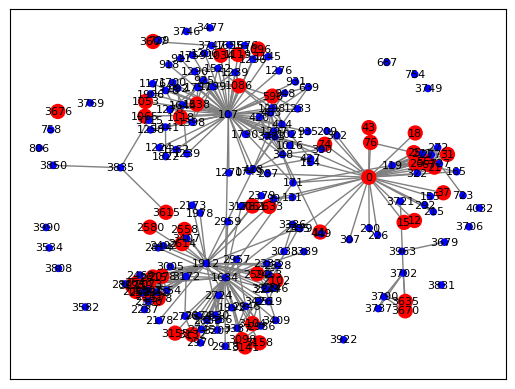

In [65]:
G_viz = G.subgraph(nodes_to_plot)
pos = nx.spring_layout(G_viz, k = 7 / np.sqrt(len(G_viz)), iterations=100)

nx.draw_networkx_nodes(G_viz, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_viz, pos, edge_color='gray')
# outlier_labels = {node: f"Outlier {node}" for node in outlier_nodes if node in G_viz}
nx.draw_networkx_labels(G_viz, pos, font_size=8)
plt.show()

### Edge Density Anomalies

for each neighbors we create their subgraph (using their edges) then:

$$
\text{anomaly score} = 1 - \text{density}
$$

In [55]:
edge_anomaly_scores = {}

for u, v in tqdm(G.edges(), desc="Analyzing edges"):
    # Get neighborhoods of both nodes
    u_neighbors = set(G.neighbors(u)) | {u}
    v_neighbors = set(G.neighbors(v)) | {v}
    combined_neighbors = u_neighbors | v_neighbors

    if len(combined_neighbors) < 3:
        continue

    # Create subgraph of combined neighborhood
    subgraph = G.subgraph(combined_neighbors)

    # Calculate actual edges vs possible edges
    actual_edges = subgraph.number_of_edges()
    n = len(combined_neighbors)
    possible_edges = n * (n - 1)

    if possible_edges > 0:
        density = actual_edges / possible_edges
        # Anomaly: edges in low-density regions
        anomaly_score = 1 - density
        edge_anomaly_scores[(u, v)] = anomaly_score


Analyzing edges:   0%|          | 0/88234 [00:00<?, ?it/s]

In [56]:
anomalous_edges = sorted(edge_anomaly_scores.items(), key=lambda x: x[1], reverse=True)[:50]

print(f"Top 10 most anomalous edges:")
for (u, v), score in anomalous_edges[:10]:
    print(f"  Edge ({u} -> {v}): anomaly score {score:.4f}")

Top 10 most anomalous edges:
  Edge (107 -> 1684): anomaly score 0.9871
  Edge (698 -> 3437): anomaly score 0.9848
  Edge (0 -> 107): anomaly score 0.9841
  Edge (1085 -> 3437): anomaly score 0.9832
  Edge (567 -> 3437): anomaly score 0.9826
  Edge (857 -> 3437): anomaly score 0.9822
  Edge (862 -> 3437): anomaly score 0.9821
  Edge (3437 -> 3438): anomaly score 0.9820
  Edge (3437 -> 3439): anomaly score 0.9820
  Edge (3437 -> 3440): anomaly score 0.9820


## recommendation system

example: citation network

### Centrality-Based Recommendation
Recommend items (papers) that are most "important" or "influential" in the network.

How it works:
- We treat the citation network as a web of influence
- Papers that are highly cited (high degree centrality) are considered important
- Papers that act as bridges between different research areas (**high betweenness centrality**) are valuable connectors
- Papers that are cited by other important papers (**high PageRank**) have prestige

> Good for new users who need "greatest hits" recommendations <br>
Effective for discovering foundational papers in a field <br>
Useful when you want to recommend universally important content <br>

>Limitations:<br>
Doesn't personalize to individual user interests <br>
May overlook niche but relevant papers <br>
Tends to recommend already popular items <br>

<br>
<br>

### Jaccard Similarity Recommendation
Recommend papers that are most similar to papers you already like, based on shared citations.

How it works:
- If two papers cite many of the same references, they're probably about similar topics
- We calculate the similarity score:
\begin{equation}
\frac{\text{shared references}}{\text{total unique references between both papers}}
\end{equation}
- Higher scores indicate more semantic similarity
- "People who cited these papers also cited those papers"

> Excellent for content-based filtering <br>
Great when you have clear examples of what the user likes <br>
Works well for academic papers where citation patterns reveal topic similarity <br>

> Limitations: <br>
Can't discover serendipitous connections outside citation patterns <br>
May create "filter bubbles" - only shows similar content <br>
Requires papers to have overlapping citation patterns <br>

<br>
<br>

### Embedding-Based Recommendation (Node2Vec/Graph Embeddings)
Learn latent representations of papers in a continuous vector space where similar papers are close together.

How it works:
- We use random walks to capture the local and global network structure
- Each paper gets represented as a dense vector (embedding)
- Papers that are "close" in the network (either directly connected or structurally similar) end up with similar vectors
- We find recommendations by looking for nearest neighbors in this embedding space

>Can capture complex, non-obvious relationships <br>
Discovers papers that are structurally similar even if they don't share direct  <br>citations
Excellent for serendipitous discovery and cross-disciplinary recommendations <br>

> Limitations:<br>
Computationally more expensive <br>
Harder to interpret why recommendations were made ("black box") <br>
Requires careful tuning of parameters <br>

<br>

- Centrality answers: "What are the most important papers everyone should read?"
- Jaccard answers: "What papers are most similar to the papers I already like?"
- Embeddings answer: "What papers exist in the same intellectual neighborhood as my interests?"

In [66]:
def centrality_recommendation(G, centralities, top_k=10):
    score = {}
    for node in G.nodes():
        degree_score = centralities['degree_centrality'].get(node, 0)
        betweenness_score = centralities['betweenness_centrality'].get(node, 0)
        pagerank_score = centralities['pagerank'].get(node, 0)

        score[node] = 0.4 * pagerank_score + 0.3 * betweenness_score + 0.3 * degree_score

    top_papers = sorted(score.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return top_papers

In [67]:
centrality_recommendation(G, centralities_df)

[(107, 0.22456743622849717),
 (1684, 0.16272711017557118),
 (1912, 0.12643151533068175),
 (3437, 0.1145193721090258),
 (0, 0.07218770664276142),
 (1085, 0.04984708267501891),
 (698, 0.04017798713075356),
 (567, 0.03376661134460969),
 (348, 0.02935204099029732),
 (428, 0.02814855917629147)]

In [68]:
def jaccard_recommendation(G, target_node, top_k = 10):
    target_neighbors = set(G.neighbors(target_node))
    jaccard_scores = {}

    for node in G.nodes():
        if node == target_node:
            continue

        node_neighbors = set(G.neighbors(node))

        if target_neighbors and node_neighbors:
            intersection = len(target_neighbors & node_neighbors)
            union = len(target_neighbors | node_neighbors)
            similarity = intersection / union if union > 0 else 0

        if similarity > 0:
            jaccard_scores[node] = similarity

    top_recommendations = sorted(jaccard_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return top_recommendations

In [69]:
jaccard_recommendation(G, 20)

[(343, 0.7368421052631579),
 (116, 0.6),
 (326, 0.5454545454545454),
 (149, 0.5263157894736842),
 (226, 0.5263157894736842),
 (2, 0.47058823529411764),
 (312, 0.4642857142857143),
 (333, 0.4375),
 (14, 0.42857142857142855),
 (144, 0.42857142857142855)]

In [ ]:
def node2vec_recommendations(G, model, target_node, top_k=10):

    # Get all node embeddings
    node_embeddings = {}
    for node in tqdm(G.nodes(), desc = 'Embedding calculation'):
        node_embeddings[node] = model.wv[node]


    target_embedding = node_embeddings[target_node].reshape(1, -1)
    similarities = {}

    for node, embedding in tqdm(node_embeddings.items(), desc = 'Similarity calculation'):
        if node != target_node:
            similarities[node] = cosine_similarity(target_embedding, embedding.reshape(1, -1))[0][0]

    top_similar = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return top_similar

In [73]:
help(Node2Vec.fit)

Help on function fit in module node2vec.node2vec:

fit(self, **skip_gram_params) -> gensim.models.word2vec.Word2Vec
    Creates the embeddings using gensim's Word2Vec.
    :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
        taken from the Node2Vec 'dimensions' parameter
    :type skip_gram_params: dict
    :return: A gensim word2vec model



In [ ]:
# Define Node2Vec embedding and train it
node2vec = Node2Vec(G, dimensions = 64, walk_length = 30, num_walks = 200, workers = 4)
model = node2vec.fit(window = 10, min_count = 1, batch_words = 4) # A gensim word2vec model so we can pass it's arguments

In [71]:
node2vec_recommendations(G, model, 20, top_k=10, dimensions=64)

Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Embedding calculation:   0%|          | 0/4039 [00:00<?, ?it/s]

Similarity calculation:   0%|          | 0/4039 [00:00<?, ?it/s]

[(73, 0.94999206),
 (58, 0.94422734),
 (166, 0.93727267),
 (374, 0.93491113),
 (17, 0.9342896),
 (26, 0.93298477),
 (144, 0.9320002),
 (155, 0.9310876),
 (99, 0.9307207),
 (75, 0.9303361)]